In [1]:
import pickle

import em
from models import RBFInterpolatorModel, load_data


# Transformer 0.65um 


Octagonal transformer in TSMC 65 um. 1T + overlaped (balun)


In [2]:
#turn and freq independent @ 28GHz SRF > 38GHz
sub_spaces = [(1,1, "_balun"), (1,1, ""), (2,2, "_balun")]


def ranges(df_train, df_test):
    df_test = df_test[df_test.Dinp > 30]
    df_test = df_test[df_test.Wp > 5]
    df_test = df_test[df_test.Dinp < 170 ]

    return  df_train, df_test


model_table = {}
for subsp in sub_spaces:
    print(f"Subspace: {subsp}")
    for f in range(201):

        freq, x_train, y_train, x_test, y_test, srf_data = load_data("../data/transf_65nm/", f, srf=3, nt=subsp, n_samples=1000, filter=ranges)
        
        if 'balun' in subsp[2]:
            m = RBFInterpolatorModel(degree=4)
            m.fit(x_train[:,[0,1]], y_train)
            pred = m.predict(x_test[:,[0,1]])
        else:
            m = RBFInterpolatorModel(degree=5)
            m.fit(x_train, y_train)
            pred = m.predict(x_test)

        if (max_mean_error := max(em.mape_lq_diff(freq, pred, y_test)[0])) > 10 :
            print(f"{f} : {max_mean_error}")

        mdl = {
                'freq_index': f,
                'freq': freq[0],
                'nt': subsp,
                'RBFmodel': m
        }
        model_table[(subsp, f)] = mdl

    srf_m = RBFInterpolatorModel(degree=3)
    if 'balun' in subsp[2]:
        srf_m.fit(srf_data[0][:, [0,1]], srf_data[1][:, [0]])
    else:
        srf_m.fit(srf_data[0], srf_data[1])
        
    srf_mdl = {
            'srf_limit': 3,
            'nt': subsp,
            'RBFmodel': srf_m
    }
    model_table[(subsp, 'srf')] = srf_mdl


Subspace: (1, 1, '_balun')
55 : 10.964429688873107
78 : 13.206343426325954
84 : 42.684563189223866
129 : 13.075760168572279
176 : 15.019236823185734
Subspace: (1, 1, '')
123 : 17.35102752911099
129 : 54.583935491844315
132 : 19.148016077951045
133 : 19.742641789138318
135 : 21.936530557772993
137 : 10.579505085375285
138 : 14.119663544777293
140 : 57.71487842865688
144 : 14.643025900615664
145 : 140.19977918840476
151 : 11.100203819472124
157 : 54.68819624371128
163 : 184.92399066386818
164 : 12.76425312038965
165 : 10.18607411564802
169 : 35.43660676244567
170 : 11.65336931023036
171 : 18.04821960785161
173 : 16.663745476585337
174 : 25.763611407846998
175 : 17.082683128503046
180 : 137.74410094243956
181 : 10.243344395955774
192 : 11.941765173740885
194 : 94.80827751557516
197 : 15.360029095625812
199 : 10.532193437522285
200 : 10.954040286275902
Subspace: (2, 2, '_balun')
35 : 13.343134964929035
61 : 14.529184155405845
75 : 40.18842280583223
86 : 18.541853147567828
88 : 10.568966825

In [3]:
model_table['inputs'] = ['Dinp', 'Wp', 'Dins', 'Ws']
model_table['ouputs'] = em.COLUMNS_6P[1:]
model_table['device'] = 'transf'
model_table['model'] = 'transf'
model_table['ranges'] = {'dinp': (25, 240), 'wp': (4, 14), 'np': (1,2), 'dins': (25, 240), 'ws': (4, 14), 'ns': (1,2), 'freq': (0, 200)}
model_table['key'] = {'nt':sub_spaces, 'f':(0, 201)}

with open("../PASSIVES_RBF_TRANSF_BALUN_28G_SRF38_v2.model",'wb') as outfile:
    pickle.dump(model_table, outfile)  

In [4]:
#with open("../../em-model/PASSIVES_RBF_TRANSF_BALUN_28G_SRF38_v1.model",'rb') as infile:
#    model = pickle.load(infile)

 #   model['ranges'] = {'dinp': (25, 240), 'wp': (4, 14), 'np': (1,2), 'dins': (25, 240), 'ws': (4, 14), 'ns': (1,2), 'freq': (0, 200)}

#with open("../../em-model/PASSIVES_RBF_TRANSF_BALUN_28G_SRF38_full_range.model",'wb') as outfile:
 #   pickle.dump(model, outfile) 

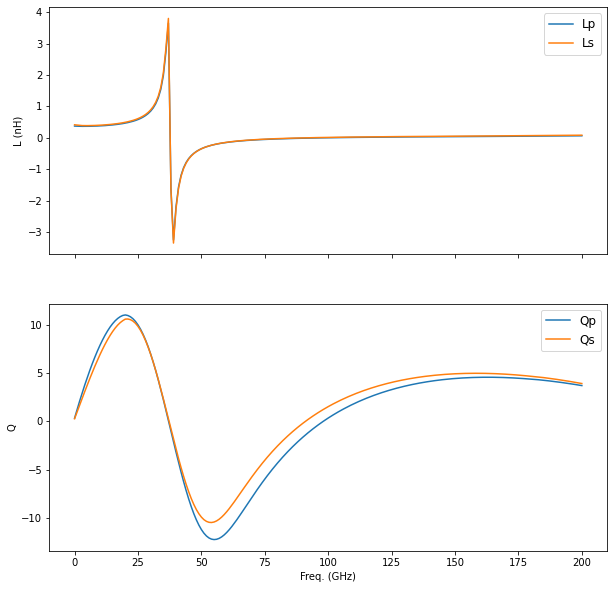

In [5]:
from models import PassivesModel

tranf_model = PassivesModel("../../em-model/PASSIVES_RBF_TRANSF_BALUN_28G_SRF38_v1.model")
resp, resp_arg = tranf_model.simulate(np=2, ns=2, dinp=45, wp=5, dins=45, ws=5) 
tranf_model.save(sri_fname="../test_out_in.sri", lq_fname= "../test_out_in.out")
tranf_model.plot()


###### Copyright (C) 2022 Instituto de Telecomunicações & IMSE CSIC